# Regression techniques using apache spark mllib

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

## Data reading and preprocessing

In [2]:
# reading data from csv file locally
df = spark.read.format("csv").option("header", "true").load("linear_reg.csv")

In [6]:
# viewing dataframe
df.show(10)

+---+---+
|  x|  y|
+---+---+
|  1|  2|
|  2|  4|
|  3|  6|
|  4|  8|
|  5| 10|
|  6| 12|
|  7| 14|
|  8| 16|
|  9| 18|
| 10| 20|
+---+---+
only showing top 10 rows



In [35]:
# caching our dataframe
df.cache()

DataFrame[x: string, y: string]

In [70]:
# changing columns datatype to int 
df = df.withColumn("x", df["x"].cast('int')).withColumn("y", df["y"].cast('int'))


## Plotting

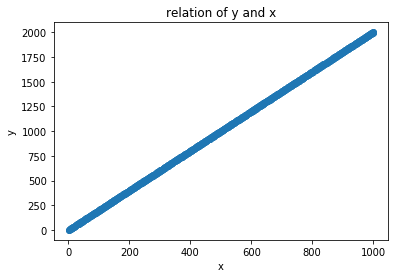

In [71]:
# sampling and plotting the dataframe
import pandas as pd
import matplotlib.pyplot as plt
sampled_data = df.select('x','y').sample(False, 0.8).toPandas()
plt.scatter(sampled_data.x,sampled_data.y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('relation of y and x')
plt.show()

In [74]:
# check correlation
df.stat.corr('x','y')

1.0

In [75]:
from pyspark.ml.feature import VectorAssembler

In [78]:
vectorAssembler = VectorAssembler(inputCols = ['x'], outputCol = 'features')

In [79]:
v_df = vectorAssembler.transform(df)
v_df = v_df.select(['features', 'y'])
v_df.show(3)

+--------+---+
|features|  y|
+--------+---+
|   [1.0]|  2|
|   [2.0]|  4|
|   [3.0]|  6|
+--------+---+
only showing top 3 rows



## Implementing linear regression

In [84]:
from pyspark.ml.regression import LinearRegression

In [81]:
splits = v_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [92]:
# creating object
lr = LinearRegression(featuresCol = 'features', labelCol='y', maxIter=100, regParam=0.3, elasticNetParam=0.8)

In [93]:
# fitting training data
lr_model = lr.fit(train_df)

In [94]:
# coefficients and intercepts
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [1.9989478735633717]
Intercept: 0.5213139721084235


In [95]:
# training summary
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 0.299968
r2: 1.000000


In [89]:
# testing details
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","y","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="y",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+---+--------+
|        prediction|  y|features|
+------------------+---+--------+
|2.5202618456717953|  2|   [1.0]|
|  8.51710546636191|  8|   [4.0]|
|16.512896960615397| 16|   [8.0]|
| 24.50868845486888| 24|  [12.0]|
|26.507636328432255| 26|  [13.0]|
+------------------+---+--------+
only showing top 5 rows

R Squared (R2) on test data = 1


In [97]:
# root mean squared error on test data
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 0.311726


## Implementing Decision Tree Regressor

In [103]:
# creating object and fitting
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'y')
dt_model = dt.fit(train_df)


In [104]:
# predicting 
dt_predictions = dt_model.transform(test_df)
dt_predictions.show()


+--------+---+------------------+
|features|  y|        prediction|
+--------+---+------------------+
|   [1.0]|  2| 33.80952380952381|
|   [4.0]|  8| 33.80952380952381|
|   [8.0]| 16| 33.80952380952381|
|  [12.0]| 24| 33.80952380952381|
|  [13.0]| 26| 33.80952380952381|
|  [14.0]| 28| 33.80952380952381|
|  [19.0]| 38| 33.80952380952381|
|  [25.0]| 50| 33.80952380952381|
|  [27.0]| 54| 33.80952380952381|
|  [28.0]| 56| 33.80952380952381|
|  [29.0]| 58| 33.80952380952381|
|  [30.0]| 60| 33.80952380952381|
|  [32.0]| 64| 33.80952380952381|
|  [33.0]| 66| 33.80952380952381|
|  [36.0]| 72| 33.80952380952381|
|  [43.0]| 86|102.72727272727273|
|  [45.0]| 90|102.72727272727273|
|  [46.0]| 92|102.72727272727273|
|  [50.0]|100|102.72727272727273|
|  [54.0]|108|102.72727272727273|
+--------+---+------------------+
only showing top 20 rows



In [ ]:
# evaluating
dt_evaluator = RegressionEvaluator(labelCol="y", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)


dt_evaluator1 = RegressionEvaluator(labelCol="y", predictionCol="prediction", metricName="r2")
r2 = dt_evaluator1.evaluate(dt_predictions)
print("r2 on test data = %g" % r2)

## Implementing Gradient-boosted tree regression

In [108]:
# creating object, fitting and predicting
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'y', maxIter=10)
gbt_model = gbt.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)
gbt_predictions.select('prediction', 'y', 'features').show(5)

+-----------------+---+--------+
|       prediction|  y|features|
+-----------------+---+--------+
|33.80952380952381|  2|   [1.0]|
|33.80952380952381|  8|   [4.0]|
|33.80952380952381| 16|   [8.0]|
|33.80952380952381| 24|  [12.0]|
|33.80952380952381| 26|  [13.0]|
+-----------------+---+--------+
only showing top 5 rows



In [110]:
# evaluating 
gbt_evaluator = RegressionEvaluator(labelCol="y", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

gbt_evaluator1 = RegressionEvaluator(labelCol="y", predictionCol="prediction", metricName="r2")
r2 = gbt_evaluator1.evaluate(gbt_predictions)
print("R2 on test data = %g" % r2)

Root Mean Squared Error (RMSE) on test data = 18.9831
R2 on test data = 0.998971


## Implementing Random forest regression

In [112]:
# creating object, fitting and predicting
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(featuresCol="features",labelCol = 'y',maxDepth=5)
rf_model = gbt.fit(train_df)
rf_predictions = rf_model.transform(test_df)
rf_predictions.select('prediction', 'y', 'features').show(5)

+-----------------+---+--------+
|       prediction|  y|features|
+-----------------+---+--------+
|33.80952380952381|  2|   [1.0]|
|33.80952380952381|  8|   [4.0]|
|33.80952380952381| 16|   [8.0]|
|33.80952380952381| 24|  [12.0]|
|33.80952380952381| 26|  [13.0]|
+-----------------+---+--------+
only showing top 5 rows



In [113]:
# evaluating 
rf_evaluator = RegressionEvaluator(labelCol="y", predictionCol="prediction", metricName="rmse")
rmse = rf_evaluator.evaluate(rf_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

rf_evaluator1 = RegressionEvaluator(labelCol="y", predictionCol="prediction", metricName="r2")
r2 = rf_evaluator1.evaluate(rf_predictions)
print("R2 on test data = %g" % r2)

Root Mean Squared Error (RMSE) on test data = 18.9831
R2 on test data = 0.998971


## Conclusion
### Linear regresion is woking very well among each regrassor with r2=1.